In [12]:
push!(LOAD_PATH, "../../julia/")

5-element Array{String,1}:
 "@"
 "@v#.#"
 "@stdlib"
 "../../julia/"
 "../../julia/"

In [13]:
#using Distributed

#while Distributed.nprocs() < Sys.CPU_THREADS/2 + 1
#    Distributed.addprocs(1)
#end

#@everywhere resize!(LOAD_PATH, length($LOAD_PATH)), copyto!(LOAD_PATH, $LOAD_PATH)

#Distributed.nprocs()


In [14]:
using Distributed
using FileIO
using PyPlot
using Distributions
using StatsBase
using BJRG
using KernelDensity
using Infections
using SparseArrays
using Twitter
import TwitterPlots
using TomekUtils

┌ Info: Precompiling KernelDensity [5ab0869b-81aa-558d-bb23-cbf5423bbe9b]
└ @ Base loading.jl:1260
┌ Info: Precompiling Infections [top-level]
└ @ Base loading.jl:1260
┌ Info: Precompiling Twitter [top-level]
└ @ Base loading.jl:1260
┌ Info: Precompiling TwitterPlots [top-level]
└ @ Base loading.jl:1260


In [15]:
using PyPlot

import PyCall
PyCall.PyDict(matplotlib."rcParams")["pgf.rcfonts"] = false
#PyCall.PyDict(matplotlib."rcParams")["text.latex.preamble"] 
PyCall.PyDict(matplotlib."rcParams")["font.family"] = "lmodern"
PyCall.PyDict(matplotlib."rcParams")["font.size"] = "8"

PyCall.PyDict(matplotlib."rcParams")["lines.markersize"] = 3
PyCall.PyDict(matplotlib."rcParams")["lines.linewidth"] = 1
PyCall.PyDict(matplotlib."rcParams")["legend.fontsize"] = "small"

PyCall.PyDict(matplotlib."rcParams")["savefig.bbox"] = "tight"
PyCall.PyDict(matplotlib."rcParams")["pgf.texsystem"] = "pdflatex"
PyCall.PyDict(matplotlib."rcParams")["text.usetex"] = true
PyCall.PyDict(matplotlib."rcParams")["pgf.preamble"] = [
         raw"\usepackage[utf8x]{inputenc}",
         raw"\usepackage[T1]{fontenc}",
         raw"\usepackage{lmodern}"
         ]

plot_dir = "/Users/tomek/Dropbox/Doktorat/Rozprawa/plots/"
TwitterPlots.set_plot_dir(plot_dir)
TwitterPlots.plot_dir

half_plot_size = (2.75,2.75)
quarter_plot_size = (1,1)
bar_plot_size = (2.75,1.5)
fat_plot_size = (2.75, 2.25)

density_plot_size = (2.75, 1.75)

(2.75, 1.75)

In [16]:
adj_15m = FileIO.load("data/15m.jld2")["adj"];

if false
    r1 = @spawn Twitter.follower_similar_scalar(adj_15m,0.1,5.0);
    r2 = @spawn Twitter.follower_similar(adj_15m);
    r3 = @spawn Twitter.follower_similar(adj_15m, shuffled=true);

    save("data/estimates-15m.jld2",
        "adj_sca", fetch(r1),
        "adj_est", fetch(r2),
        "adj_shu", fetch(r3),
        compress=true)
    finalize.([r1,r2,r3])
end
    

data = load("data/estimates-15m.jld2")

adj_est_15m = data["adj_est"];
adj_shu_15m = data["adj_shu"];
adj_sca_15m = data["adj_sca"];

In [71]:
size(adj_15m), count(adj_15m), 87569^2

((87569, 87569), 6030459, 7668329761)

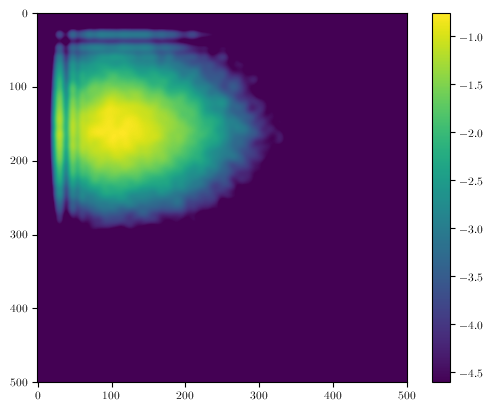

PyObject <matplotlib.colorbar.Colorbar object at 0x7feab262f790>

In [72]:
using KernelDensity

adj=adj_shu_15m
log_deg_in  = sum(adj, dims=1) |> vec .|> log10 .|> x-> max(-1,x)
log_deg_out = sum(adj, dims=2) |> vec .|> log10 .|> x-> max(-1,x)

density = kde(
    (log_deg_in, log_deg_out), 
    npoints=(2048,2048), 
    boundary=((0,6), (0,6)),
    bandwidth=(0.05,0.05)
    )

x = 0:0.01:5
y = 0:0.01:5
z = pdf(density, x, y ) .|> x->max(0.01,x) .|> log

imshow(z)

xmax = 4
ymax = 4
#xlim(0, xmax)
#ylim(0, ymax)
#xticks( 0:xmax, 0:xmax .|> x-> raw"$10^"*string(x)*raw"$")
#yticks( 0:ymax, 0:ymax .|> x-> raw"$10^"*string(x)*raw"$")
colorbar()


In [73]:
println(fieldnames(typeof(density)))
density.x, density.y

(:x, :y, :density)


(0.0:0.0029311187103077674:6.0, 0.0:0.0029311187103077674:6.0)

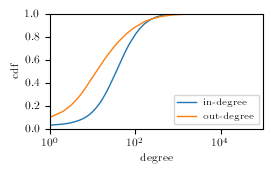

In [74]:
TwitterPlots.degree_ecdf_plot(adj_15m,"15m", fig=figure(figsize=bar_plot_size))

In [75]:
gammas = exp10.(-1:0.02:1);
#likelihoods = [Twitter.likelihood_scalar(adj_15m, Twitter.follower_estimate_scalar(adj_15m, gamma), gamma) for gamma in gammas];
gammas = exp10.(-1:0.02:1);
likelihoods = Vector{Float64}(undef, size(gammas))
Threads.@threads for i in 1:length(gammas)
  gamma = gammas[i]
  likelihood = Twitter.likelihood_scalar(adj_15m, Twitter.follower_estimate_scalar(adj_15m, gamma), gamma)
  likelihoods[i] = likelihood
end
gamma = gammas[argmax(likelihoods)]

0.6918309709189365

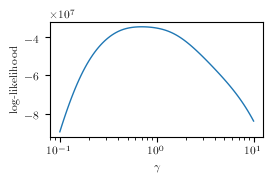

In [76]:
TwitterPlots.gamma_plot(gammas, likelihoods, "15m", fig=figure(figsize=bar_plot_size))

In [77]:
#PyCall.PyDict(matplotlib."rcParams")["font.size"] = "6"

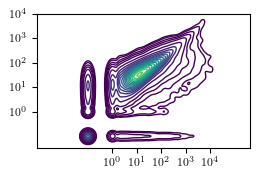

In [17]:
TwitterPlots.inoutdeg_corr_contour(adj_15m,"15m", fig=figure(figsize=density_plot_size))

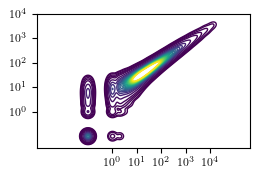

In [18]:
TwitterPlots.inoutdeg_corr_contour(adj_sca_15m, "sca_15m", fig=figure(figsize=density_plot_size))

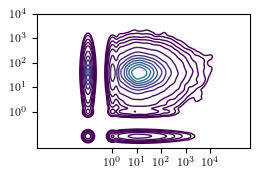

In [19]:
TwitterPlots.inoutdeg_corr_contour(adj_shu_15m, "shu_15m", fig=figure(figsize=density_plot_size))

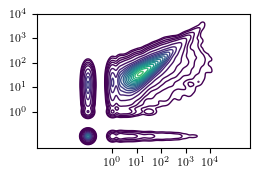

In [20]:
TwitterPlots.inoutdeg_corr_contour(adj_est_15m, "est_15m", fig=figure(figsize=density_plot_size))

In [82]:
#reload("TwitterPlots.jl")
if false
    #reload("Twitter.jl")
    Twitter.computeinfections("15m", "data/infections_15m.jld2", exp10.(-4:0.04:0),
        adj_15m, adj_est_15m, adj_shu_15m, adj_sca_15m, 0.7);
end
data = load("data/infections_15m.jld2");

In [83]:
data |> keys

Base.KeySet for a Dict{String,Any} with 38 entries. Keys:
  "scc_shu"
  "contact_theo_ind"
  "scc_est"
  "resistance_theo_sca"
  "prevalence_est"
  "contact_shu"
  "prevalence_sca"
  "resistance_est"
  "scc_theo_ind"
  "outbreak_est"
  "outbreak_theo_sca"
  "scc"
  "outbreak_theo"
  "scc_theo"
  "resistance_theo_ind"
  "outbreak_sca"
  "prevalence_theo"
  "outbreak_shu"
  "resistance_sca"
  "prevalence_theo_sca"
  "resistance_shu"
  "datasetname"
  "contact_sca"
  "prevalence_theo_ind"
  "outbreak_theo_ind"
  ⋮

In [84]:
PyCall.PyDict(matplotlib."rcParams")["font.size"] = "8"

"8"

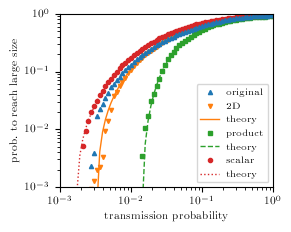

In [85]:
TwitterPlots.forward_epidemics_plot(data, fig=figure(figsize=fat_plot_size))

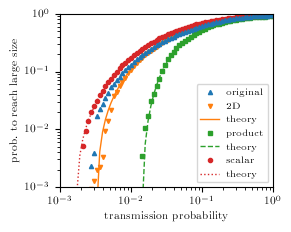

In [86]:
TwitterPlots.forward_epidemics_plot(data, fig=figure(figsize=fat_plot_size))

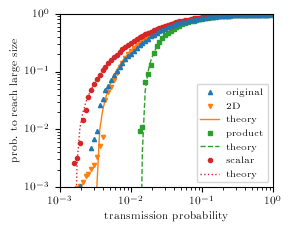

In [87]:
TwitterPlots.backward_epidemics_plot(data, fig=figure(figsize=fat_plot_size))

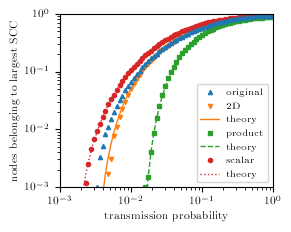

In [88]:
TwitterPlots.scc_plot(data, fig=figure(figsize=fat_plot_size))

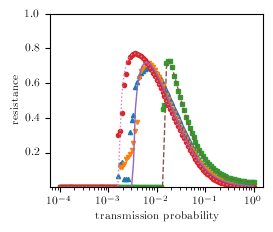

In [89]:
TwitterPlots.resistances_plot(data, fig=figure(figsize=fat_plot_size))

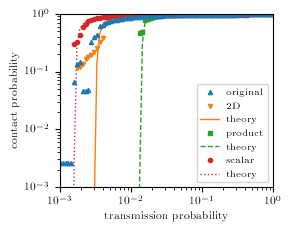

In [90]:
TwitterPlots.contacts_plot(data, fig=figure(figsize=fat_plot_size))

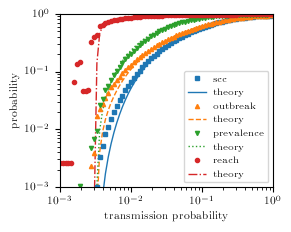

In [91]:
TwitterPlots.original_epidemics_plot(data, fig=figure(figsize=fat_plot_size))

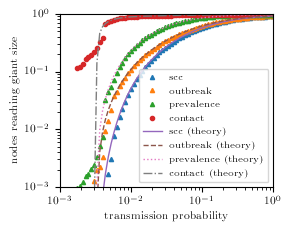

In [92]:
TwitterPlots.estimated_epidemics_plot(data, fig=figure(figsize=fat_plot_size))

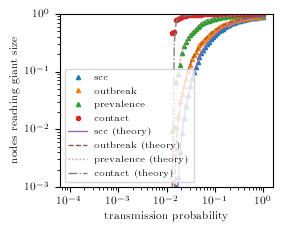

In [93]:
TwitterPlots.estimated_independent_epidemics_plot(data, fig=figure(figsize=fat_plot_size))

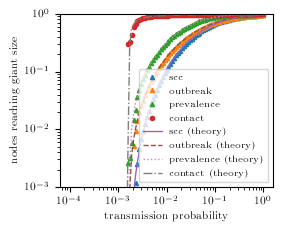

In [94]:
TwitterPlots.estimated_scalar_epidemics_plot(data, fig=figure(figsize=fat_plot_size))

In [65]:
outbreak_prevalence_dichotomy_plot(data)

LoadError: UndefVarError: outbreak_prevalence_dichotomy_plot not defined